In [1]:
from keras.layers import Input, Conv2D, BatchNormalization, ReLU, MaxPooling2D, Concatenate, GlobalMaxPooling2D, Dropout, Dense, Lambda, Reshape, Activation, Multiply, Add
from keras.callbacks import ReduceLROnPlateau, ModelCheckpoint, TensorBoard
from keras.layers import Input, Dropout, Dense, GlobalAveragePooling2D
from transformers import TFSwinForImageClassification, AutoImageProcessor
from keras.models import Sequential, Model
from keras import backend as K
from tensorflow import keras
import tensorflow as tf
import numpy as np
import sys
sys.path.append("/root/autodl-tmp/training_tool/")
from training_tool import load_data, draw_curve, draw_matrix, TimeHistory

2025-04-09 22:42:46.939976: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


100%|██████████| 186/186 [00:01<00:00, 168.58it/s]


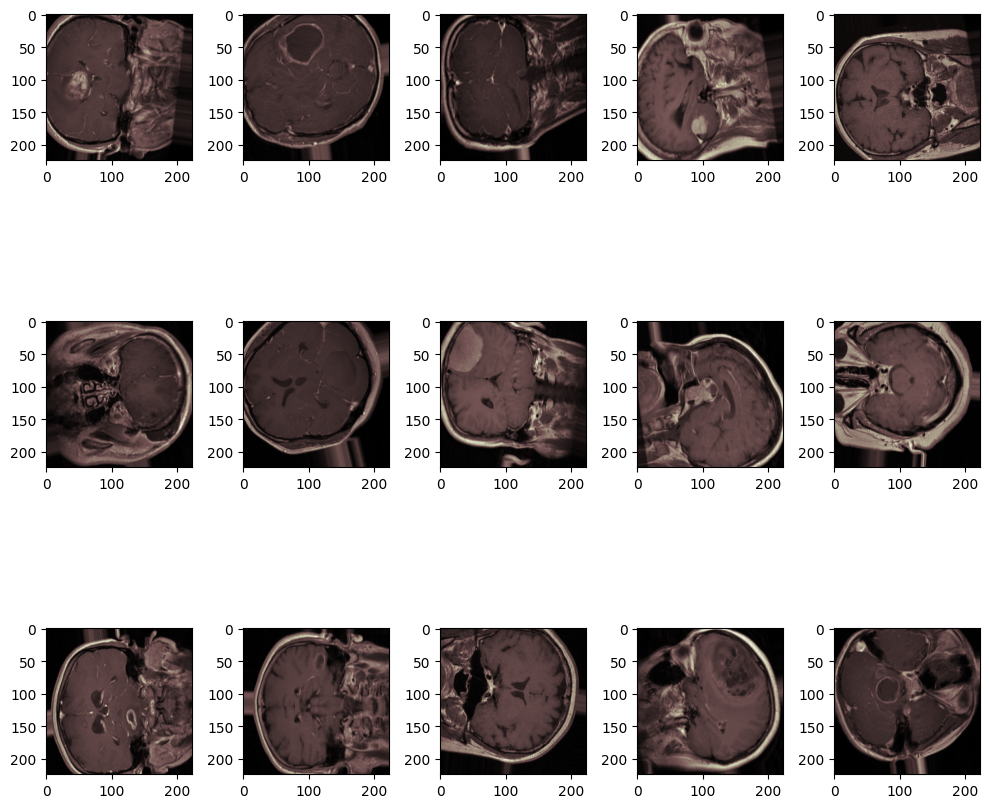

(614, 224, 224, 3)
(10534, 224, 224, 3)
(614, 3)
(10534, 3)


In [2]:
labels = ['glioma', 'meningioma', 'pituitary']
data_path = '/root/autodl-tmp/dataset/figshare_MBTD/augmented'
image_size = 224
x_train, x_test, y_train, y_test = load_data(data_path, labels, image_size)

In [34]:
x_train = x_train[:10500, :, :, :]
y_train = y_train[:10500, :]
x_test = x_test[:600, :, :, :]
y_test = y_test[:600, :]

print(x_train.shape)
print(x_test.shape)

(10500, 224, 224, 3)
(600, 224, 224, 3)


In [17]:
model = TFSwinForImageClassification.from_pretrained('/root/autodl-tmp/swinViT', num_labels=1000, ignore_mismatched_sizes=True)

model.classifier = tf.keras.Sequential([
    Dropout(0.5),
    Dense(3, activation='softmax')
])

processor = AutoImageProcessor.from_pretrained('/root/autodl-tmp/swinViT')
def preprocess(x):
    x = (x - 0.5) / 0.5  
    x = tf.transpose(x, [0, 3, 1, 2]) 
    return x

inputs = Input(shape=(224, 224, 3))
x = tf.keras.layers.Lambda(preprocess)(inputs)
outputs = model(x)
model = Model(inputs=inputs, outputs=outputs)

adam = keras.optimizers.Adam(learning_rate=0.0001)
model.compile(optimizer=adam, loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()



All PyTorch model weights were used when initializing TFSwinForImageClassification.

All the weights of TFSwinForImageClassification were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFSwinForImageClassification for predictions without further training.


Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 lambda_1 (Lambda)           (None, 3, 224, 224)       0         
                                                                 
 tf_swin_for_image_classific  TFSwinImageClassifierOut  86803923 
 ation_1 (TFSwinForImageClas  put(loss=None, logits=(N           
 sification)                 one, 3),                            
                              hidden_states=None, att            
                             entions=None, reshaped_h            
                             idden_states=None)                  
                                                                 
Total params: 86,803,923
Trainable params: 86,746,299
Non-trainable params: 57,624
__________________________________________

In [18]:
tensorboard = TensorBoard(log_dir = 'logs')
checkpoint = ModelCheckpoint(filepath='model-swim.h5',
                             monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')
reduce_lr = ReduceLROnPlateau(monitor = 'val_accuracy', factor = 0.3, patience = 5, min_delta = 0.001,
                              mode='auto',verbose=1)
time_callback = TimeHistory()
history = model.fit(x_train,y_train,validation_split=0.1, epochs =15, verbose=1, batch_size=30,
                   callbacks=[tensorboard,checkpoint,reduce_lr, time_callback])

Epoch 1/15


315/315 [==============================] - ETA: 0s - loss: 0.7467 - accuracy: 0.6484
Epoch 1: val_accuracy improved from -inf to 0.83714, saving model to model-swim.h5
Epoch 1: 170.48 seconds
315/315 [==============================] - 170s 373ms/step - loss: 0.7467 - accuracy: 0.6484 - val_loss: 0.4062 - val_accuracy: 0.8371 - lr: 1.0000e-04
Epoch 2/15
315/315 [==============================] - ETA: 0s - loss: 0.3702 - accuracy: 0.8613
Epoch 2: val_accuracy improved from 0.83714 to 0.87810, saving model to model-swim.h5
Epoch 2: 92.19 seconds
315/315 [==============================] - 92s 293ms/step - loss: 0.3702 - accuracy: 0.8613 - val_loss: 0.3438 - val_accuracy: 0.8781 - lr: 1.0000e-04
Epoch 3/15
315/315 [==============================] - ETA: 0s - loss: 0.3033 - accuracy: 0.8856
Epoch 3: val_accuracy improved from 0.87810 to 0.91524, saving model to model-swim.h5
Epoch 3: 92.04 seconds
315/315 [==============================] - 92s 292ms/step - loss: 0.3033 - accuracy: 0.8856 - v

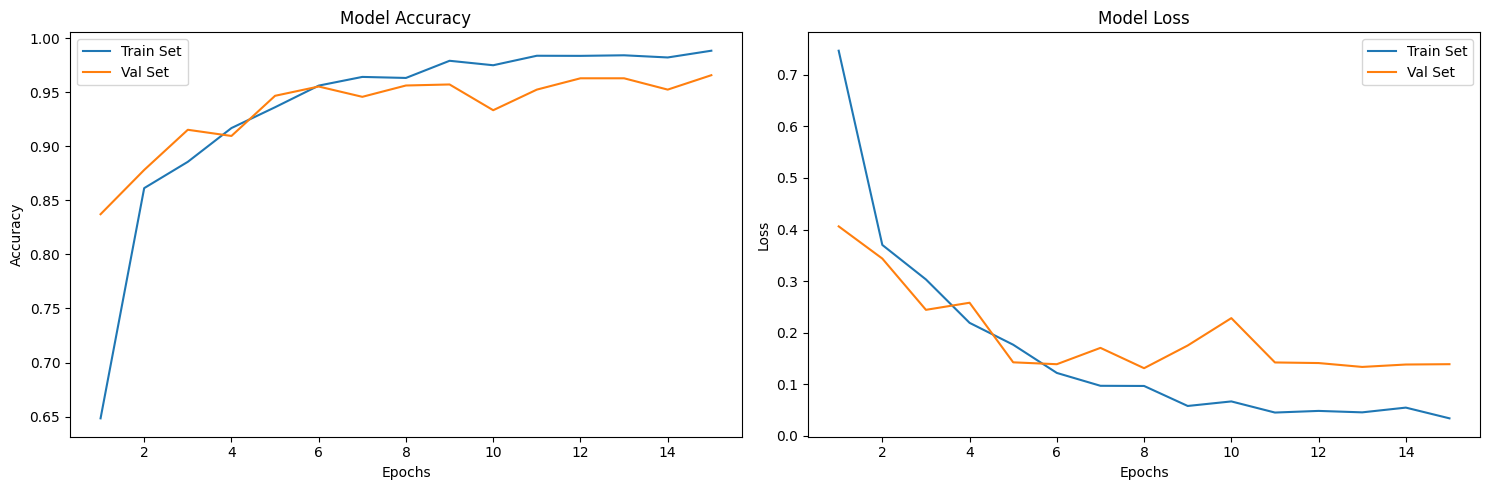

20/20 [==============================] - 2s 117ms/step - loss: 0.2034 - accuracy: 0.9483
Test Accuracy:  94.83
              precision    recall  f1-score   support

      glioma     0.9925    0.9231    0.9565       286
  meningioma     0.8616    0.9648    0.9103       142
   pituitary     0.9600    0.9767    0.9683       172

    accuracy                         0.9483       600
   macro avg     0.9380    0.9549    0.9450       600
weighted avg     0.9522    0.9483    0.9490       600



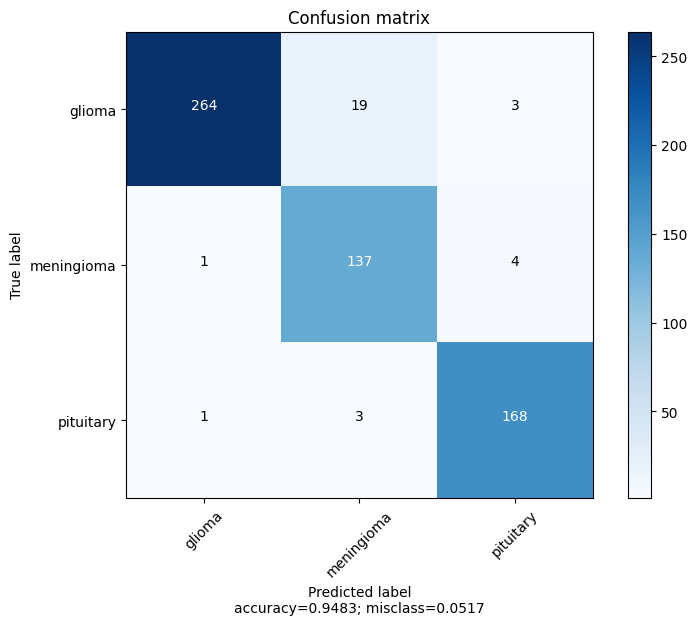

In [33]:
draw_curve(history)
pred = model.predict(x_test, batch_size=30)
pred = np.argmax(pred.logits,axis=1)
y_test_new = np.argmax(y_test,axis=1)
loss,acc = model.evaluate(x_test,y_test,verbose = 1, batch_size=30)
draw_matrix(labels, y_test_new, pred, acc)

All PyTorch model weights were used when initializing TFSwinForImageClassification.

All the weights of TFSwinForImageClassification were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFSwinForImageClassification for predictions without further training.


Epoch 1/15
315/315 [==============================] - ETA: 0s - loss: 0.7273 - accuracy: 0.6600
Epoch 1: val_accuracy improved from -inf to 0.84857, saving model to model-swim.h5
Epoch 1: 171.39 seconds
315/315 [==============================] - 171s 358ms/step - loss: 0.7273 - accuracy: 0.6600 - val_loss: 0.4123 - val_accuracy: 0.8486 - lr: 1.0000e-04
Epoch 2/15
315/315 [==============================] - ETA: 0s - loss: 0.4179 - accuracy: 0.8387
Epoch 2: val_accuracy did not improve from 0.84857
Epoch 2: 87.55 seconds
315/315 [==============================] - 88s 278ms/step - loss: 0.4179 - accuracy: 0.8387 - val_loss: 0.4512 - val_accuracy: 0.8095 - lr: 1.0000e-04
Epoch 3/15
315/315 [==============================] - ETA: 0s - loss: 0.3255 - accuracy: 0.8754
Epoch 3: val_accuracy improved from 0.84857 to 0.89714, saving model to model-swim.h5
Epoch 3: 93.34 seconds
315/315 [==============================] - 93s 296ms/step - loss: 0.3255 - accuracy: 0.8754 - val_loss: 0.2628 - val_ac

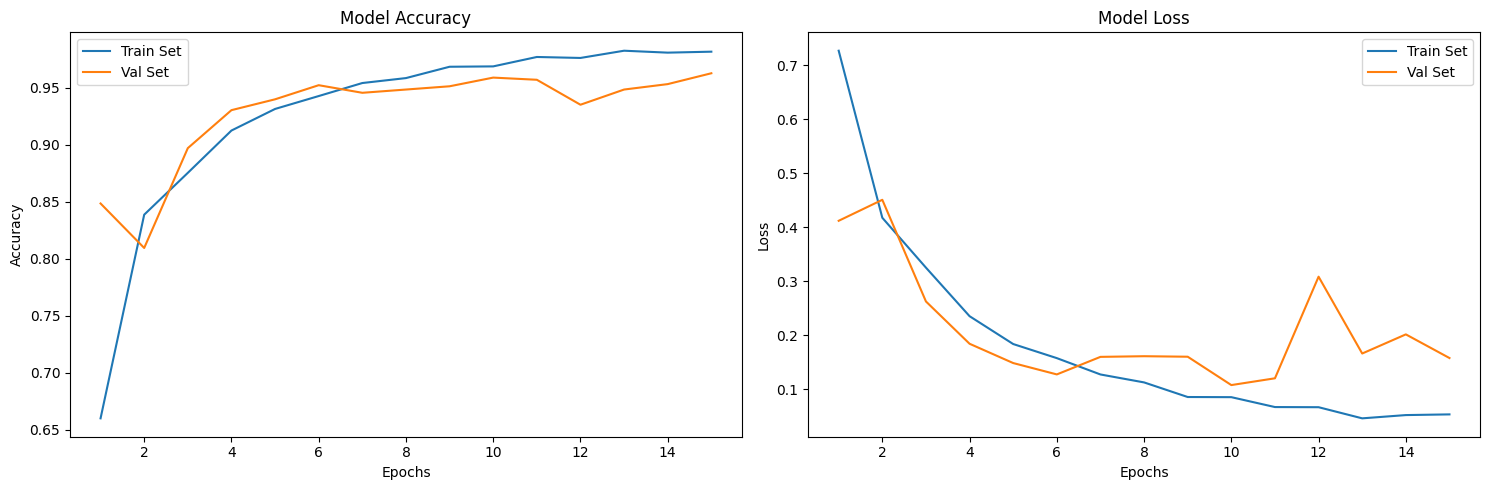

20/20 [==============================] - 2s 107ms/step - loss: 0.2183 - accuracy: 0.9383
Test Accuracy:  93.83
              precision    recall  f1-score   support

      glioma     0.9813    0.9196    0.9495       286
  meningioma     0.8636    0.9366    0.8986       142
   pituitary     0.9382    0.9709    0.9543       172

    accuracy                         0.9383       600
   macro avg     0.9277    0.9424    0.9341       600
weighted avg     0.9411    0.9383    0.9388       600



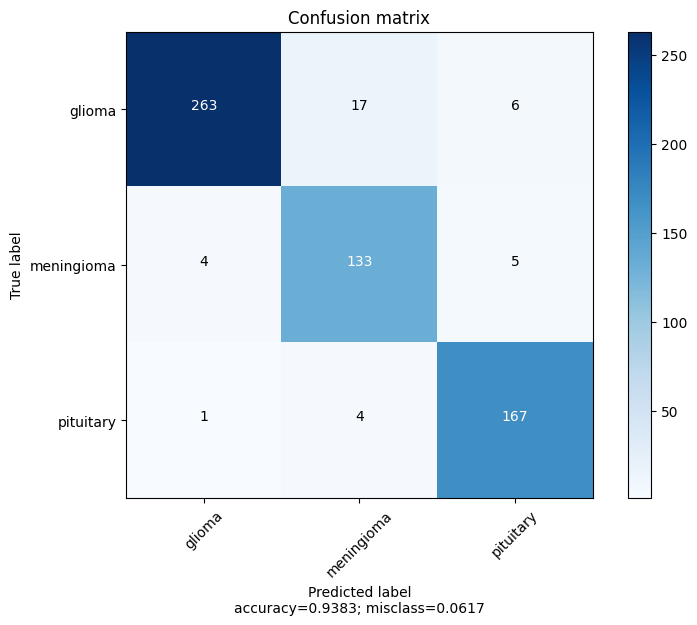

In [35]:
model = TFSwinForImageClassification.from_pretrained('/root/autodl-tmp/swinViT', num_labels=1000, ignore_mismatched_sizes=True)

model.classifier = tf.keras.Sequential([
    Dropout(0.5),
    Dense(3, activation='softmax')
])

processor = AutoImageProcessor.from_pretrained('/root/autodl-tmp/swinViT')
def preprocess(x):
    x = (x - 0.5) / 0.5  
    x = tf.transpose(x, [0, 3, 1, 2]) 
    return x

inputs = Input(shape=(224, 224, 3))
x = tf.keras.layers.Lambda(preprocess)(inputs)
outputs = model(x)
model = Model(inputs=inputs, outputs=outputs)

adam = keras.optimizers.Adam(learning_rate=0.0001)
model.compile(optimizer=adam, loss='categorical_crossentropy', metrics=['accuracy'])

tensorboard = TensorBoard(log_dir = 'logs')
checkpoint = ModelCheckpoint(filepath='model-swim.h5',
                             monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')
reduce_lr = ReduceLROnPlateau(monitor = 'val_accuracy', factor = 0.3, patience = 5, min_delta = 0.001,
                              mode='auto',verbose=1)
time_callback = TimeHistory()
history = model.fit(x_train,y_train,validation_split=0.1, epochs =15, verbose=1, batch_size=30,
                   callbacks=[tensorboard,checkpoint,reduce_lr, time_callback])

draw_curve(history)
pred = model.predict(x_test, batch_size=30)
pred = np.argmax(pred.logits,axis=1)
y_test_new = np.argmax(y_test,axis=1)
loss,acc = model.evaluate(x_test,y_test,verbose = 1, batch_size=30)
draw_matrix(labels, y_test_new, pred, acc)


All PyTorch model weights were used when initializing TFSwinForImageClassification.

All the weights of TFSwinForImageClassification were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFSwinForImageClassification for predictions without further training.


Epoch 1/15
315/315 [==============================] - ETA: 0s - loss: 0.8143 - accuracy: 0.6058
Epoch 1: val_accuracy improved from -inf to 0.81714, saving model to model-swim.h5
Epoch 1: 164.56 seconds
315/315 [==============================] - 165s 356ms/step - loss: 0.8143 - accuracy: 0.6058 - val_loss: 0.4787 - val_accuracy: 0.8171 - lr: 1.0000e-04
Epoch 2/15
315/315 [==============================] - ETA: 0s - loss: 0.4414 - accuracy: 0.8306
Epoch 2: val_accuracy improved from 0.81714 to 0.83905, saving model to model-swim.h5
Epoch 2: 86.33 seconds
315/315 [==============================] - 86s 274ms/step - loss: 0.4414 - accuracy: 0.8306 - val_loss: 0.4155 - val_accuracy: 0.8390 - lr: 1.0000e-04
Epoch 3/15
315/315 [==============================] - ETA: 0s - loss: 0.3371 - accuracy: 0.8694
Epoch 3: val_accuracy improved from 0.83905 to 0.90667, saving model to model-swim.h5
Epoch 3: 88.87 seconds
315/315 [==============================] - 89s 282ms/step - loss: 0.3371 - accuracy:

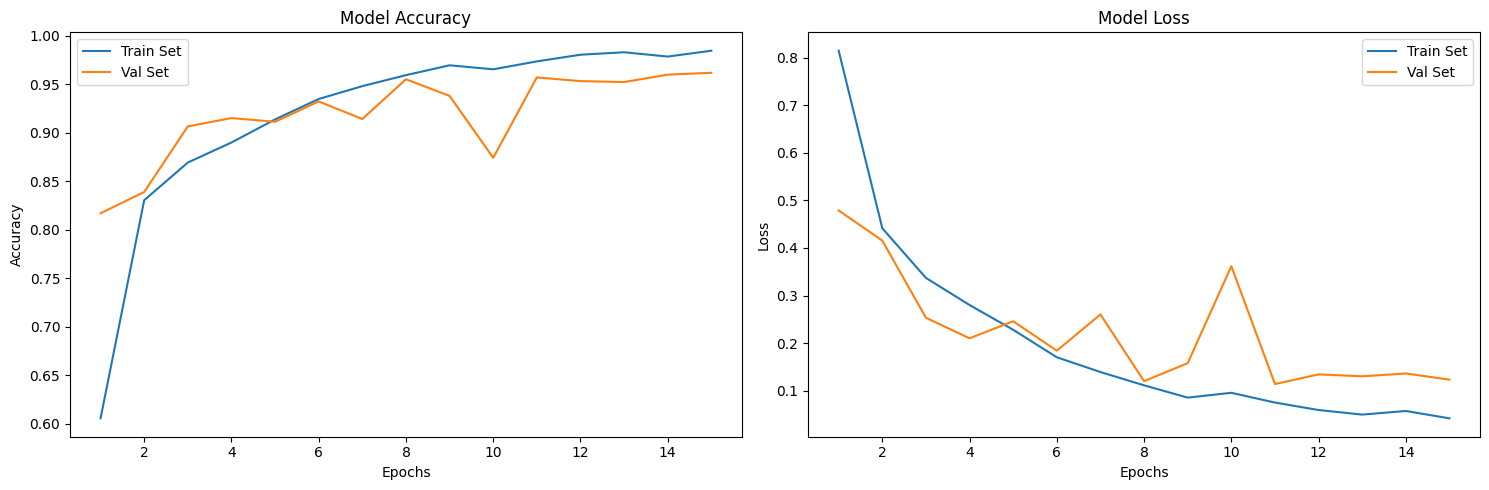

20/20 [==============================] - 2s 112ms/step - loss: 0.1508 - accuracy: 0.9583
Test Accuracy:  95.83
              precision    recall  f1-score   support

      glioma     0.9752    0.9615    0.9683       286
  meningioma     0.9048    0.9366    0.9204       142
   pituitary     0.9766    0.9709    0.9738       172

    accuracy                         0.9583       600
   macro avg     0.9522    0.9564    0.9542       600
weighted avg     0.9589    0.9583    0.9585       600



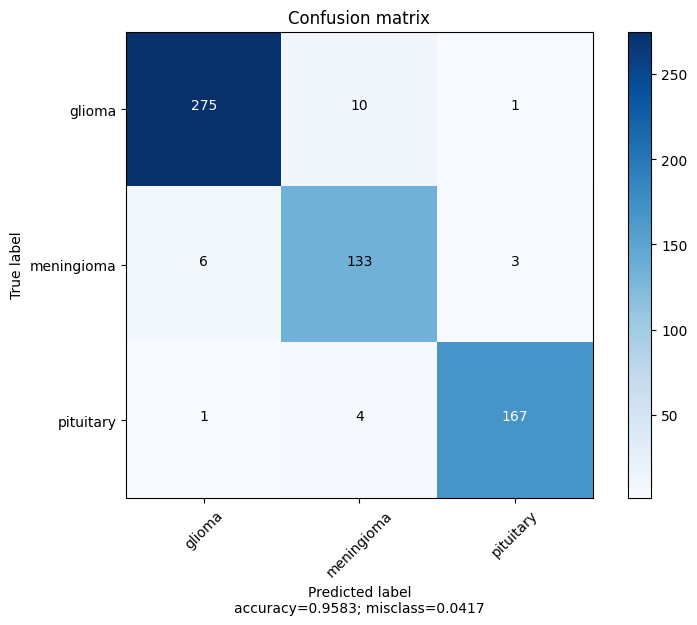

In [36]:
model = TFSwinForImageClassification.from_pretrained('/root/autodl-tmp/swinViT', num_labels=1000, ignore_mismatched_sizes=True)

model.classifier = tf.keras.Sequential([
    Dropout(0.5),
    Dense(3, activation='softmax')
])

processor = AutoImageProcessor.from_pretrained('/root/autodl-tmp/swinViT')
def preprocess(x):
    x = (x - 0.5) / 0.5  
    x = tf.transpose(x, [0, 3, 1, 2]) 
    return x

inputs = Input(shape=(224, 224, 3))
x = tf.keras.layers.Lambda(preprocess)(inputs)
outputs = model(x)
model = Model(inputs=inputs, outputs=outputs)

adam = keras.optimizers.Adam(learning_rate=0.0001)
model.compile(optimizer=adam, loss='categorical_crossentropy', metrics=['accuracy'])

tensorboard = TensorBoard(log_dir = 'logs')
checkpoint = ModelCheckpoint(filepath='model-swim.h5',
                             monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')
reduce_lr = ReduceLROnPlateau(monitor = 'val_accuracy', factor = 0.3, patience = 5, min_delta = 0.001,
                              mode='auto',verbose=1)
time_callback = TimeHistory()
history = model.fit(x_train,y_train,validation_split=0.1, epochs =15, verbose=1, batch_size=30,
                   callbacks=[tensorboard,checkpoint,reduce_lr, time_callback])

draw_curve(history)
pred = model.predict(x_test, batch_size=30)
pred = np.argmax(pred.logits,axis=1)
y_test_new = np.argmax(y_test,axis=1)
loss,acc = model.evaluate(x_test,y_test,verbose = 1, batch_size=30)
draw_matrix(labels, y_test_new, pred, acc)

All PyTorch model weights were used when initializing TFSwinForImageClassification.

All the weights of TFSwinForImageClassification were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFSwinForImageClassification for predictions without further training.


Epoch 1/15
315/315 [==============================] - ETA: 0s - loss: 0.7985 - accuracy: 0.6139
Epoch 1: val_accuracy improved from -inf to 0.84190, saving model to model-swim.h5
Epoch 1: 171.97 seconds
315/315 [==============================] - 172s 356ms/step - loss: 0.7985 - accuracy: 0.6139 - val_loss: 0.4434 - val_accuracy: 0.8419 - lr: 1.0000e-04
Epoch 2/15
315/315 [==============================] - ETA: 0s - loss: 0.4133 - accuracy: 0.8375
Epoch 2: val_accuracy improved from 0.84190 to 0.88000, saving model to model-swim.h5
Epoch 2: 86.93 seconds
315/315 [==============================] - 87s 276ms/step - loss: 0.4133 - accuracy: 0.8375 - val_loss: 0.3277 - val_accuracy: 0.8800 - lr: 1.0000e-04
Epoch 3/15
315/315 [==============================] - ETA: 0s - loss: 0.3059 - accuracy: 0.8819
Epoch 3: val_accuracy improved from 0.88000 to 0.91619, saving model to model-swim.h5
Epoch 3: 87.33 seconds
315/315 [==============================] - 87s 277ms/step - loss: 0.3059 - accuracy:

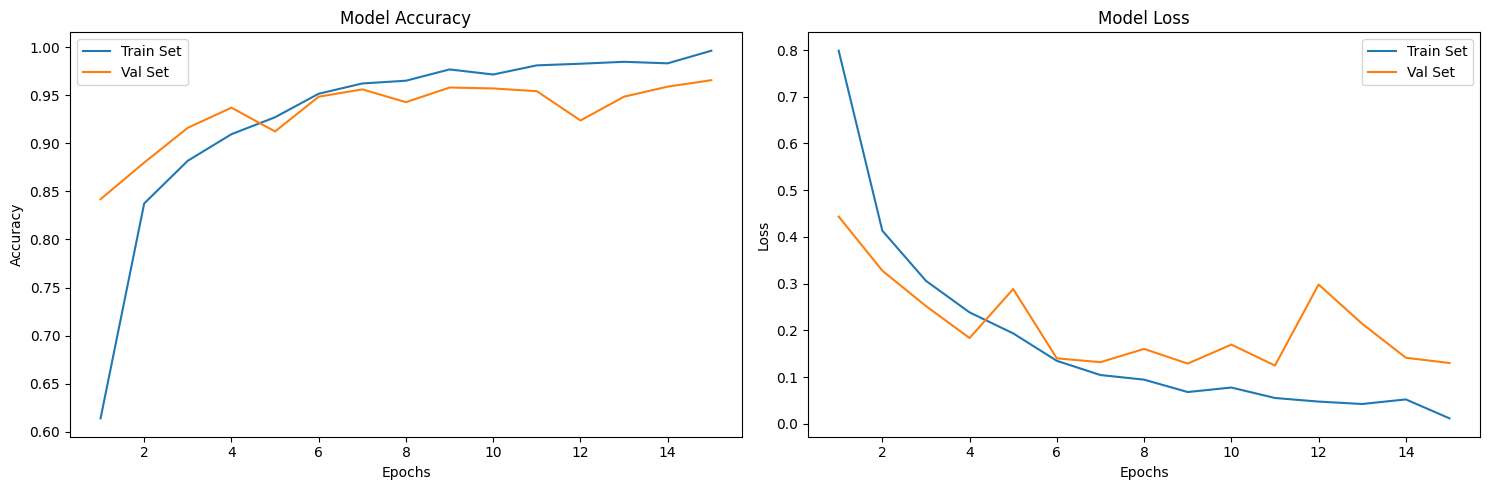

20/20 [==============================] - 2s 110ms/step - loss: 0.2173 - accuracy: 0.9567
Test Accuracy:  95.67
              precision    recall  f1-score   support

      glioma     0.9752    0.9615    0.9683       286
  meningioma     0.9091    0.9155    0.9123       142
   pituitary     0.9657    0.9826    0.9741       172

    accuracy                         0.9567       600
   macro avg     0.9500    0.9532    0.9516       600
weighted avg     0.9568    0.9567    0.9567       600



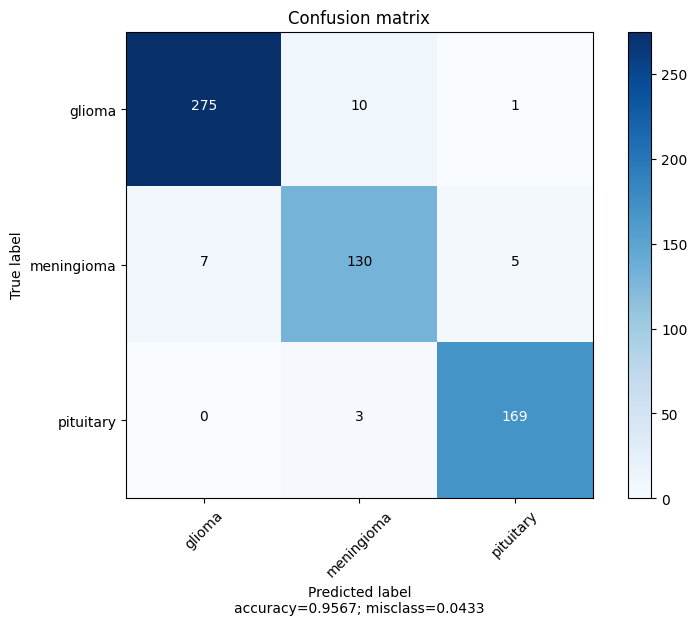

In [37]:
model = TFSwinForImageClassification.from_pretrained('/root/autodl-tmp/swinViT', num_labels=1000, ignore_mismatched_sizes=True)

model.classifier = tf.keras.Sequential([
    Dropout(0.5),
    Dense(3, activation='softmax')
])

processor = AutoImageProcessor.from_pretrained('/root/autodl-tmp/swinViT')
def preprocess(x):
    x = (x - 0.5) / 0.5  
    x = tf.transpose(x, [0, 3, 1, 2]) 
    return x

inputs = Input(shape=(224, 224, 3))
x = tf.keras.layers.Lambda(preprocess)(inputs)
outputs = model(x)
model = Model(inputs=inputs, outputs=outputs)

adam = keras.optimizers.Adam(learning_rate=0.0001)
model.compile(optimizer=adam, loss='categorical_crossentropy', metrics=['accuracy'])

tensorboard = TensorBoard(log_dir = 'logs')
checkpoint = ModelCheckpoint(filepath='model-swim.h5',
                             monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')
reduce_lr = ReduceLROnPlateau(monitor = 'val_accuracy', factor = 0.3, patience = 5, min_delta = 0.001,
                              mode='auto',verbose=1)
time_callback = TimeHistory()
history = model.fit(x_train,y_train,validation_split=0.1, epochs =15, verbose=1, batch_size=30,
                   callbacks=[tensorboard,checkpoint,reduce_lr, time_callback])

draw_curve(history)
pred = model.predict(x_test, batch_size=30)
pred = np.argmax(pred.logits,axis=1)
y_test_new = np.argmax(y_test,axis=1)
loss,acc = model.evaluate(x_test,y_test,verbose = 1, batch_size=30)
draw_matrix(labels, y_test_new, pred, acc)

All PyTorch model weights were used when initializing TFSwinForImageClassification.

All the weights of TFSwinForImageClassification were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFSwinForImageClassification for predictions without further training.


Epoch 1/15
315/315 [==============================] - ETA: 0s - loss: 0.7386 - accuracy: 0.6542
Epoch 1: val_accuracy improved from -inf to 0.81619, saving model to model-swim.h5
Epoch 1: 175.29 seconds
315/315 [==============================] - 175s 367ms/step - loss: 0.7386 - accuracy: 0.6542 - val_loss: 0.4680 - val_accuracy: 0.8162 - lr: 1.0000e-04
Epoch 2/15
315/315 [==============================] - ETA: 0s - loss: 0.4087 - accuracy: 0.8408
Epoch 2: val_accuracy improved from 0.81619 to 0.84857, saving model to model-swim.h5
Epoch 2: 88.02 seconds
315/315 [==============================] - 88s 280ms/step - loss: 0.4087 - accuracy: 0.8408 - val_loss: 0.3741 - val_accuracy: 0.8486 - lr: 1.0000e-04
Epoch 3/15
315/315 [==============================] - ETA: 0s - loss: 0.3325 - accuracy: 0.8749
Epoch 3: val_accuracy improved from 0.84857 to 0.86667, saving model to model-swim.h5
Epoch 3: 88.69 seconds
315/315 [==============================] - 89s 282ms/step - loss: 0.3325 - accuracy:

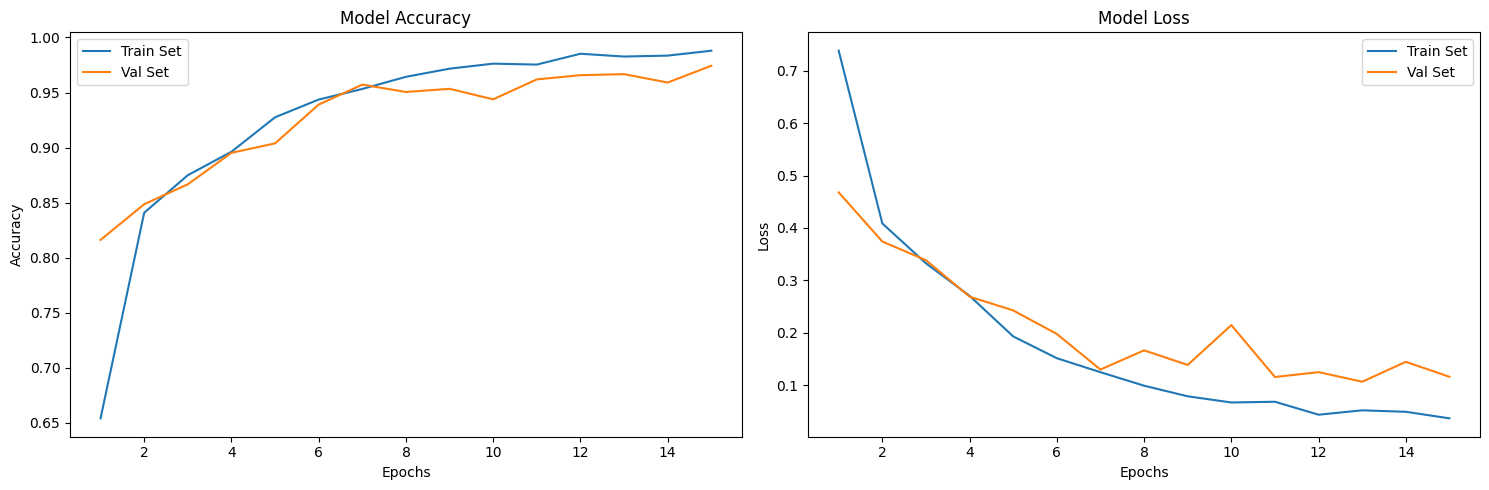

20/20 [==============================] - 2s 112ms/step - loss: 0.2284 - accuracy: 0.9533
Test Accuracy:  95.33
              precision    recall  f1-score   support

      glioma     0.9716    0.9580    0.9648       286
  meningioma     0.9161    0.9225    0.9193       142
   pituitary     0.9543    0.9709    0.9625       172

    accuracy                         0.9533       600
   macro avg     0.9473    0.9505    0.9489       600
weighted avg     0.9535    0.9533    0.9534       600



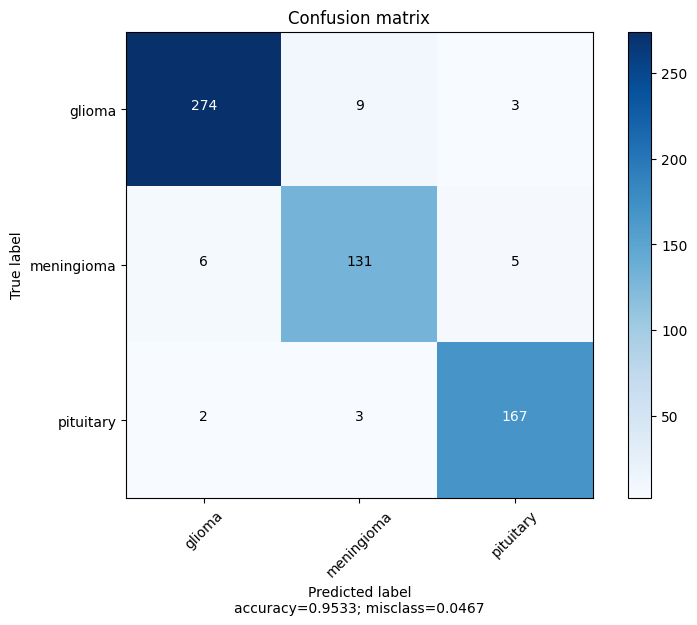

In [38]:
model = TFSwinForImageClassification.from_pretrained('/root/autodl-tmp/swinViT', num_labels=1000, ignore_mismatched_sizes=True)

model.classifier = tf.keras.Sequential([
    Dropout(0.5),
    Dense(3, activation='softmax')
])

processor = AutoImageProcessor.from_pretrained('/root/autodl-tmp/swinViT')
def preprocess(x):
    x = (x - 0.5) / 0.5  
    x = tf.transpose(x, [0, 3, 1, 2]) 
    return x

inputs = Input(shape=(224, 224, 3))
x = tf.keras.layers.Lambda(preprocess)(inputs)
outputs = model(x)
model = Model(inputs=inputs, outputs=outputs)

adam = keras.optimizers.Adam(learning_rate=0.0001)
model.compile(optimizer=adam, loss='categorical_crossentropy', metrics=['accuracy'])

tensorboard = TensorBoard(log_dir = 'logs')
checkpoint = ModelCheckpoint(filepath='model-swim.h5',
                             monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')
reduce_lr = ReduceLROnPlateau(monitor = 'val_accuracy', factor = 0.3, patience = 5, min_delta = 0.001,
                              mode='auto',verbose=1)
time_callback = TimeHistory()
history = model.fit(x_train,y_train,validation_split=0.1, epochs =15, verbose=1, batch_size=30,
                   callbacks=[tensorboard,checkpoint,reduce_lr, time_callback])

draw_curve(history)
pred = model.predict(x_test, batch_size=30)
pred = np.argmax(pred.logits,axis=1)
y_test_new = np.argmax(y_test,axis=1)
loss,acc = model.evaluate(x_test,y_test,verbose = 1, batch_size=30)
draw_matrix(labels, y_test_new, pred, acc)